In [0]:
import pyspark
from pyspark.sql import SparkSession
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [0]:
# create spark session    
spark = SparkSession.builder.appName("eda").getOrCreate()

In [0]:
# read the csv file (taken from https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)
df = spark.read.format("delta").load("dbfs:/user/hive/warehouse/heart")

## EDA

In [0]:
#%pip install handyspark

In [0]:
from pyspark.sql.functions import col, count, when, isnan
from pyspark.sql.types import IntegerType, FloatType, BooleanType, DateType, StringType
import numpy as np
import handyspark

In [0]:
df.count()

Out[7]: 1025

In [0]:
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|

In [0]:
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|               sex|                cp|          trestbps|             chol|                fbs|           restecg|           thalach|              exang|           oldpeak|             slope|                ca|              thal|            target|
+-------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             1025|              1025|              1025|              1025|             1025|               1025|              1025|              1025|            

In [0]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: string (nullable = true)
 |-- chol: string (nullable = true)
 |-- fbs: string (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalach: string (nullable = true)
 |-- exang: string (nullable = true)
 |-- oldpeak: string (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: string (nullable = true)
 |-- thal: string (nullable = true)
 |-- target: string (nullable = true)



### Null values

In [0]:
null_df = df.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '') | col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
null_df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



### Fix variable types

In [0]:
df = df.withColumn("age", df["age"].cast(IntegerType()))
df = df.withColumn("sex", df["sex"].cast(IntegerType()))
df = df.withColumn("cp", df["cp"].cast(IntegerType()))
df = df.withColumn("trestbps", df["trestbps"].cast(IntegerType()))
df = df.withColumn("chol", df["chol"].cast(IntegerType()))
df = df.withColumn("restecg", df["restecg"].cast(IntegerType()))
df = df.withColumn("thalach", df["thalach"].cast(IntegerType()))
df = df.withColumn("exang", df["exang"].cast(IntegerType()))
df = df.withColumn("oldpeak", df["oldpeak"].cast(FloatType()))
df = df.withColumn("slope", df["slope"].cast(IntegerType()))
df = df.withColumn("ca", df["ca"].cast(IntegerType()))
df = df.withColumn("thal", df["thal"].cast(IntegerType()))
df = df.withColumn("target", df["target"].cast(IntegerType()))

In [0]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: long (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



### Histograms

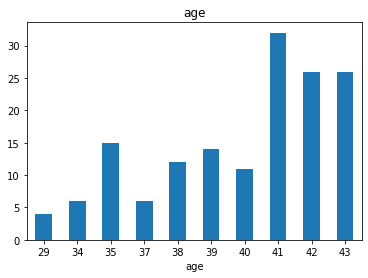

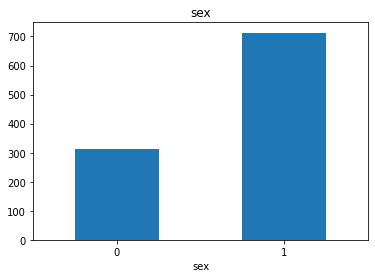

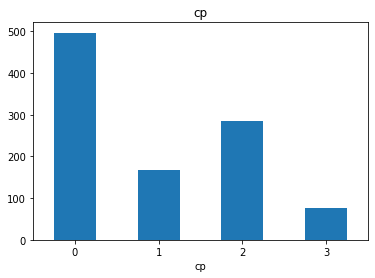

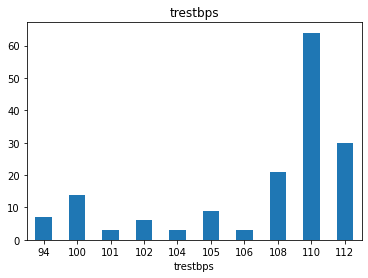

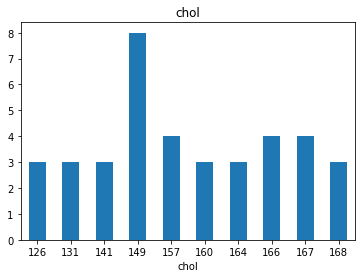

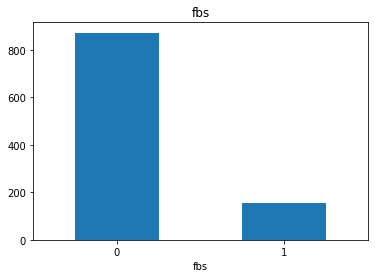

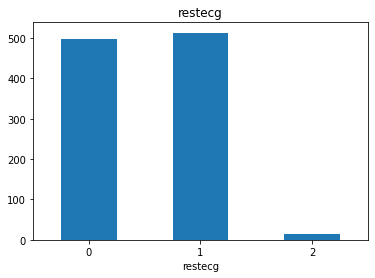

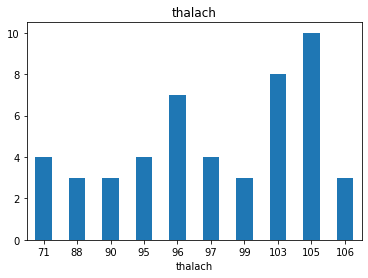

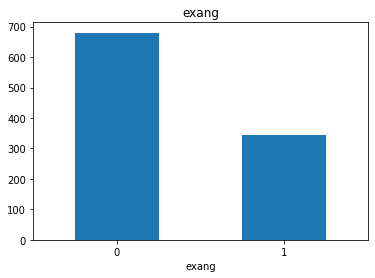

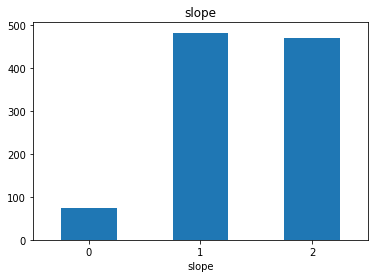

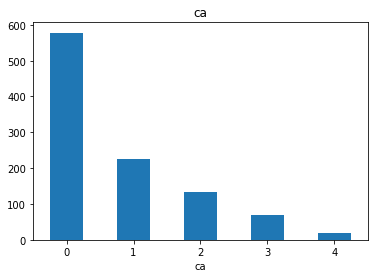

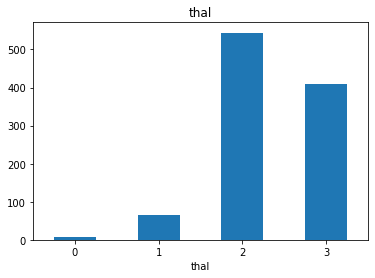

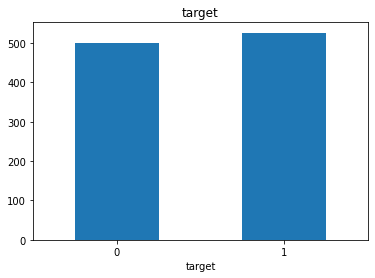

In [0]:
# convert to handy frame
hdf = df.toHandy()

for c in df.columns:
    if c == 'oldpeak':
        continue
    # Using the HandySpark hist() method to plot the histogram
    fig, axes = plt.subplots()
    hdf.cols[c].hist(bins=10, ax=axes)
    plt.title(c)
    plt.show()

### Plot scatter of each feature vs target

In [0]:
# categorize fbs and create df2
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="fbs", outputCol="fbs_cat")
df2 = indexer.fit(df).transform(df)
df2.show()
df2 = df2.withColumn("fbs_cat", df2["fbs_cat"].cast(IntegerType()))
df2 = df2.drop("fbs")

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|fbs_cat|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|    0.0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|    1.0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|    0.0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|    0.0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|    1.0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|    0.0|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|    0.0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|    

### Compute correlations

In [0]:
# filter out string columns
non_string_cols = [f.name for f in df2.schema.fields if f.dataType != StringType() and f.name != 'target']

# calculate correlations
correlations = {c: df2.stat.corr(c, 'target') for c in non_string_cols}

# print sorted corrs
corr_sort = {k: v for k, v in sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True)}
print(corr_sort)

{'oldpeak': -0.4384412713889329, 'exang': -0.43802855005584596, 'cp': 0.43485425005273703, 'thalach': 0.4228954964828724, 'ca': -0.382085289038671, 'slope': 0.3455117514359987, 'thal': -0.3378381504571859, 'sex': -0.27950075729226237, 'age': -0.2293235512676108, 'trestbps': -0.13877173373730076, 'restecg': 0.1344682087390892, 'chol': -0.09996559423254128, 'fbs_cat': -0.04116354746465123}


### Compute feature importance

In [0]:
# print cardinality of each column
for c in df.columns:
    print(f"Column {c} # unique values: {len(set(df.select(c).collect()))}")

Column age # unique values: 41
Column sex # unique values: 2
Column cp # unique values: 4
Column trestbps # unique values: 49
Column chol # unique values: 152
Column fbs # unique values: 2
Column restecg # unique values: 3
Column thalach # unique values: 91
Column exang # unique values: 2
Column oldpeak # unique values: 40
Column slope # unique values: 3
Column ca # unique values: 5
Column thal # unique values: 4
Column target # unique values: 2


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# get features
features = [col for col in df2.columns if col not in ["target"]]

# assemble features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(df2)

# train rf model
rf = RandomForestClassifier(labelCol="target", featuresCol="features", numTrees=100)

model = rf.fit(assembled_data)

# get feature importance
importances = model.featureImportances

# sort feature importances
importance_list = [importances[i] for i in range(len(features))]
sorted_importances = sorted(zip(features, importance_list), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

cp: 0.21449268924455925
ca: 0.16859745897532874
thal: 0.15083115065171196
oldpeak: 0.09896439441256286
thalach: 0.07866203385196481
exang: 0.06634157031697409
age: 0.062184186544523345
slope: 0.046851772184379754
sex: 0.03826327184040719
trestbps: 0.036761324435192304
chol: 0.025785181993641933
restecg: 0.008303295219432546
fbs_cat: 0.003961670329321223


# Export to delta file

In [0]:
df2.write.format("delta").mode("overwrite").save("dbfs:/user/hive/warehouse/heart_model")